## Hard Constraint

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import deepxde as dde
from utils.gs_solovev_sol import GS_Linear

A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

spatial_domain = dde.geometry.Ellipse(eps, kappa, delta) 

x,u = gen_traindata(100)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_test = np.concatenate((x_test, spatial_domain.random_points(n_test)))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))
bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [], #[bc135],
    num_domain=256,
    num_boundary=0,
    num_test=n_test,
    train_distribution="LHS"
)

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [10]:
######################
#  Hard Constraints  #
######################

def point_on_ellipse(x):
    tol = 1e-3
    abs_diff = np.zeros([2000, len(spatial_domain.x_ellipse), 2])
    for i in range(len(spatial_domain.x_ellipse)):
        abs_diff[:, i, :] = np.abs(x - spatial_domain.x_ellipse[i, :])
    ellipse_bool = tf.logical_not(tf.reduce_any(tf.sqrt(abs_diff[:, :, 0:1]**2 + abs_diff[:, :, 1:2]**2) <= tol, 1))
    print(ellipse_bool)
    return tf.cast(
        ellipse_bool,
        tf.float32,
    )

def modify_output(x, y):
    #hard = 1
    # We need to find a clever way to represent 
    # an inverse of the parametric equation.
    # if [x[:,0:1],x[:,1:2]] in data.train_x_bc:
    #     hard = 0

    # testing sigmoid
    print(y, spatial_domain.strictly_inside(x) * y)
    return spatial_domain.strictly_inside(x) * y

# net.apply_output_transform(modify_output)

Text(0, 0.5, '$u(r,z=0)$')

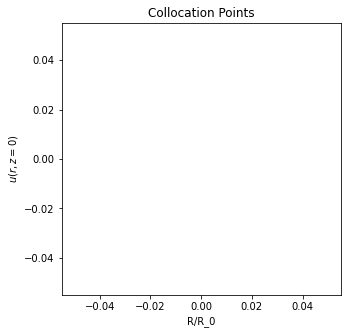

In [11]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5, 5))
ax.scatter(data.train_x_bc[:, 0], data.train_x_bc[:, 1], s=2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

## Train Model

Compiling model...
Building feed-forward neural network...
Tensor("dense_11/BiasAdd:0", shape=(None, 1), dtype=float32) Tensor("mul_1025:0", shape=(None, 1), dtype=float32)
'build' took 1.451916 s

'compile' took 3.837407 s

Initializing variables...
Training model...

0         [1.17e+00, 1.17e+02]    [1.11e+00, 1.11e+02]    []  
1         [8.92e-01, 8.92e+01]    [8.40e-01, 8.40e+01]    []  
2         [6.41e-01, 6.41e+01]    [5.97e-01, 5.97e+01]    []  
3         [3.87e-01, 3.87e+01]    [3.54e-01, 3.54e+01]    []  
4         [2.41e-01, 2.41e+01]    [2.25e-01, 2.25e+01]    []  
5         [4.22e-01, 4.22e+01]    [4.22e-01, 4.22e+01]    []  
6         [4.07e-01, 4.07e+01]    [4.10e-01, 4.10e+01]    []  
7         [2.70e-01, 2.70e+01]    [2.67e-01, 2.67e+01]    []  
8         [2.26e-01, 2.26e+01]    [2.14e-01, 2.14e+01]    []  
9         [2.70e-01, 2.70e+01]    [2.49e-01, 2.49e+01]    []  
10        [3.17e-01, 3.17e+01]    [2.91e-01, 2.91e+01]    []  
11        [3.21e-01, 3.21e+01]    [2.

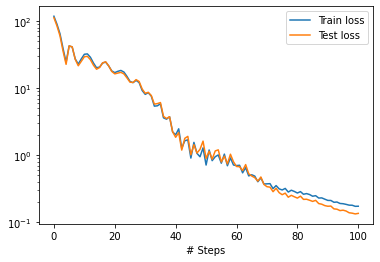

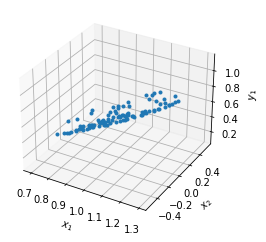

Accuracy
Mean residual: 0.053705987


In [12]:
DATE = "10272022"
CONFIG = "ITER_Hard"
LR = 2e-2
DEPTH = 3
BREADTH = 20
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN(
    [2] + DEPTH * [BREADTH] + [1], 
    AF, "Glorot normal")
net.apply_output_transform(modify_output)
model = dde.Model(data, net)

decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,100]
  )
  loss_history, train_state = model.train(epochs=100, display_every=1)
  dde.saveplot(
      loss_history,
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

#### After BFGS

Compiling model...
'compile' took 2.568667 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.72e-03, 1.72e-01]    [1.35e-03, 1.35e-01]    []  
110       [1.26e-03, 1.26e-01]    [1.26e-03, 1.26e-01]        
120       [3.11e-04, 3.11e-02]    [3.11e-04, 3.11e-02]        
130       [4.81e-05, 4.81e-03]    [4.81e-05, 4.81e-03]        
140       [2.09e-05, 2.09e-03]    [2.09e-05, 2.09e-03]        
150       [3.56e-06, 3.56e-04]    [3.56e-06, 3.56e-04]        
160       [2.72e-06, 2.72e-04]    [2.72e-06, 2.72e-04]        
170       [9.81e-07, 9.81e-05]    [9.81e-07, 9.81e-05]        
180       [8.66e-07, 8.66e-05]    [8.66e-07, 8.66e-05]        
190       [7.73e-07, 7.73e-05]    [7.73e-07, 7.73e-05]        
200       [7.71e-07, 7.71e-05]    [7.71e-07, 7.71e-05]        
210       [7.71e-07, 7.71e-05]    [7.71e-07, 7.71e-05]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Ob

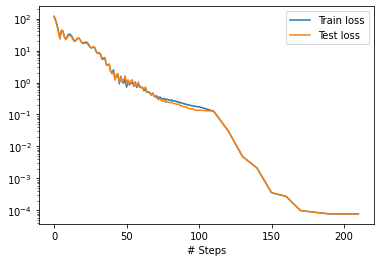

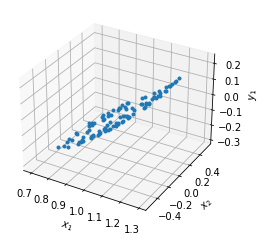

In [13]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1, 100]
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)


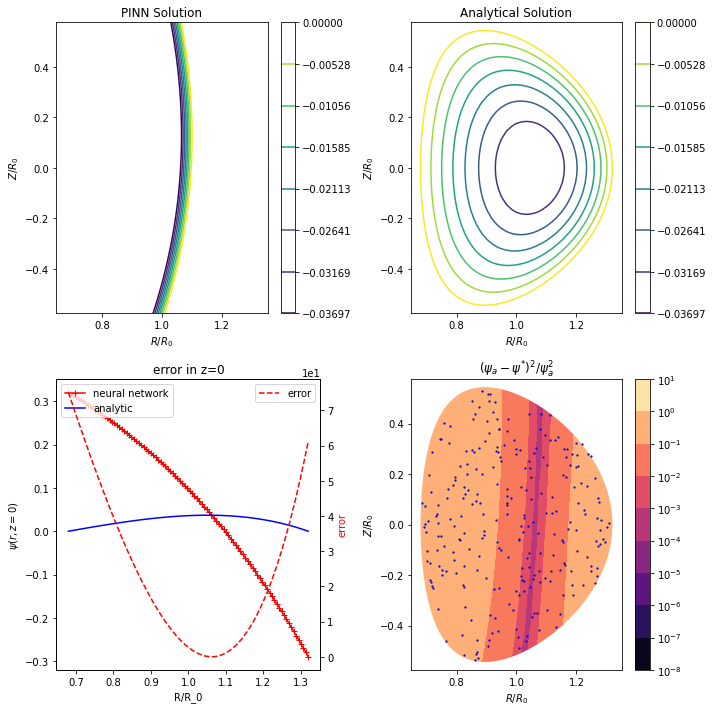

In [14]:
from utils.utils import *
ITER = GS_Linear(eps=0.32, kappa=1.7, delta=0.33)
ITER.get_BCs(A)
ITER.solve_coefficients()
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test, PATH)